## Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
ROOT = r'/content/drive/Othercomputers/My Laptop/Deep Learning/Working Code/Dataset'
os.chdir(ROOT)
assert os.getcwd() == ROOT

## Importing Libraries

In [3]:
!pip install -q stylecloud

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
import string

import plotly.express as px
import plotly.graph_objects as go


import stylecloud
from IPython.display import Image

from warnings import filterwarnings
filterwarnings('ignore')

## About Dataset

**train.csv - Feature annotations for 1000 of the patient notes, 100 for each of ten cases.**

*   **id** - Unique identifier for each patient note / feature pair.
*   **pn_num** - The patient note annotated in this row.
*   **feature_num** - The feature annotated in this row.
*   **case_num** - The case to which this patient note belongs.
*   **annotation** - The text(s) within a patient note indicating a feature. A feature may be indicated multiple times within a * single note.
*   **location** - Character spans indicating the location of each annotation within the note. Multiple spans may be needed to * represent an annotation, in which case the spans are delimited by a semicolon ;.










Reading Dataset

In [5]:
train = pd.read_csv('train.csv')

display(train.shape)


display(train.head())

(14300, 6)

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


In [6]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14300 entries, 0 to 14299
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           14300 non-null  object
 1   case_num     14300 non-null  int64 
 2   pn_num       14300 non-null  int64 
 3   feature_num  14300 non-null  int64 
 4   annotation   14300 non-null  object
 5   location     14300 non-null  object
dtypes: int64(3), object(3)
memory usage: 670.4+ KB


None

**patient_Notes.csv** - The notes description of each patient are written in patient_Notes.csv while the main feature from that description is written in train.csv given the note we need an NER approach to find the location of the main features or main key phrase in that text the location is stored as [starting_character_index_of_main_feat_in_the_text:ending_character_index_of_main_feat_in_the_text]

**patient_Notes Description** -A collection of about 40,000 Patient Note history portions. Only a subset of these have features annotated. You may wish to apply unsupervised learning techniques on the notes without annotations. The patient notes in the test set are not included in the public version of this file.

*   **pn_num** - A unique identifier for each patient note.
*   **case_num** - A unique identifier for the clinical case a patient note represents.
*   **pn_history** - The text of the encounter as recorded by the test taker.

In [7]:
notes = pd.read_csv('patient_notes.csv')

display(notes.shape)

display(notes.head())

(42146, 3)

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


Since the location of note of pn_num 16 in first row of train.csv is ['696 724'] so,

In [8]:
notes['pn_history'][16][696:724]

'dad with recent heart attcak'

In [9]:
notes['pn_history'][16]

'HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with "thyroid disease," dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms'

In [10]:
notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42146 entries, 0 to 42145
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pn_num      42146 non-null  int64 
 1   case_num    42146 non-null  int64 
 2   pn_history  42146 non-null  object
dtypes: int64(2), object(1)
memory usage: 987.9+ KB


**features.csv** - The rubric of features (or key concepts) for each clinical case.

* **feature_num** - A unique identifier for each feature.
* **case_num** - A unique identifier for each case.
* **feature_text** - A description of the feature.

In [11]:
features = pd.read_csv('features.csv')

display(features.shape)
features.head()

(143, 3)

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [12]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   feature_num   143 non-null    int64 
 1   case_num      143 non-null    int64 
 2   feature_text  143 non-null    object
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


## EDA

**Patient Notes**

In [13]:
notes_count = notes.groupby('case_num').count()

fig = px.bar(data_frame=notes_count , x = notes_count.index , y='pn_num' , color='pn_num' , color_continuous_scale="Emrld"
             , title = 'Patient Notes per case')

fig.show()

In [14]:
notes['word_count'] = notes['pn_history'].apply(lambda x : len(x.split()))

fig = px.histogram(notes , x ='word_count' , title='Patient History Word Count')

fig.show()

**Features**

In [15]:
features_count = features.groupby('case_num').count()

fig = px.bar(data_frame=features_count , x = features_count.index , y='feature_num' , color='feature_num' , color_continuous_scale="Emrld"
             , title = 'Features Distribution per case')

fig.show()

In [16]:
features['word_count'] = features['feature_text'].apply(lambda x : len(x.split('-')))

fig = px.histogram(features , x ='word_count' , title='Features Word Count')
fig.update_layout(bargap=0.1)
fig.show()

In [17]:
train.head()

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


**Patient Analysis**

In [18]:
print('Unique Patient Counts = ' , len(train['pn_num'].value_counts()))

Unique Patient Counts =  1000


In [19]:
print('Data Frame for a particular patient')
train[train['pn_num'] == 16]

Data Frame for a particular patient


,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']
5,00016_005,0,16,5,[],[]
6,00016_006,0,16,6,"['adderall', 'adderrall', 'adderrall']","['321 329', '404 413', '652 661']"
7,00016_007,0,16,7,[],[]
8,00016_008,0,16,8,[],[]
9,00016_009,0,16,9,"['palpitations', 'heart beating/pounding']","['26 38', '96 118']"


**Annotation Analysis**

In [20]:
print('Total Annotations = ', len(train['location']))
print('Number of Empty annotations and locations = ' , len(train[train['location'] == '[]']))

Total Annotations =  14300
Number of Empty annotations and locations =  4399


In [21]:
train["location"] = train["location"].apply(eval) 
train['annotation'] = train['annotation'].apply(eval) # else whole list len will be counted as 1

train["annot_count"] = 0
for i in range(len(train)):
    train["annot_count"][i] = len(train["annotation"][i])
    
print('Annotation counts:')
print(train['annot_count'].value_counts().sort_index())

Annotation counts:
0    4399
1    8181
2    1296
3     287
4      99
5      27
6       9
7       1
8       1
Name: annot_count, dtype: int64


In [22]:
fig = px.bar(data_frame=train , x = train['annot_count'].value_counts().sort_index().index ,
             y = train['annot_count'].value_counts().sort_index() , color = train['annot_count'].value_counts().sort_index() ,
             color_continuous_scale='Emrld' , title='Number of Annotations per row')

fig.update_xaxes(title= 'Number of Annotations')
fig.update_yaxes(title= 'Annotations Count')

fig.show()

In [23]:
import spacy

patient_df = train[train["pn_num"] == 16]
location  = patient_df["location"]
annotation = patient_df["annotation"]
start_pos = []
end_pos = []
for i in location:
    for j in i:
        start_pos.append(j.split()[0])
        end_pos.append(j.split()[1])
        
ents = []
for i in range(len(start_pos)):
    ents.append({
        'start': int(start_pos[i]), 
        'end' : int(end_pos[i]),
        "label" : "Annotation"
    })
doc = {
    'text' : notes[notes["pn_num"] == 16]["pn_history"].iloc[0],
    "ents" : ents
}
colors = {"Annotation" :"linear-gradient(90deg, #aa9cfc, #fc9ce7)" } 
options = {"colors": colors}
spacy.displacy.render(doc, style="ent", options = options , manual=True, jupyter=True);

## WordClouds

**Word Cloud for Features**

In [24]:
concat_features = ' '.join([i for i in features.feature_text.astype(str)])
print(concat_features[:1000])

Family-history-of-MI-OR-Family-history-of-myocardial-infarction Family-history-of-thyroid-disorder Chest-pressure Intermittent-symptoms Lightheaded No-hair-changes-OR-no-nail-changes-OR-no-temperature-intolerance Adderall-use Shortness-of-breath Caffeine-use heart-pounding-OR-heart-racing Few-months-duration 17-year Male No-vaginal-discharge Weight-loss Not-sexually-active Prior-episodes-of-diarrhea 20-year No-bloody-bowel-movements Recurrent-bouts-over-past-6-months Right-sided-LQ-abdominal-pain-OR-Right-lower-quadrant-abdominal-pain No-urinary-symptoms Diminished-appetite Normal-LMP-2-weeks-ago-OR-Normal-last-menstrual-period-2-weeks-ago 8-to-10-hours-of-acute-pain Female Prior-normal-periods Last-Pap-smear-I-year-ago IUD Sexually-active Vaginal-dryness Irregular-menses Recent-nausea-vomiting-OR-Recent-flulike-symptoms No-premenstrual-symptoms Female Stress LMP-2-months-ago-or-Last-menstrual-period-2-months-ago Hot-flashes Irregular-flow-OR-Irregular-frequency-OR-Irregular-intervals 

In [25]:
stylecloud.gen_stylecloud(text=concat_features, icon_name= "fab fa-twitter", 
                          palette="cartocolors.diverging.TealRose_7", background_color="black" , size=1024)

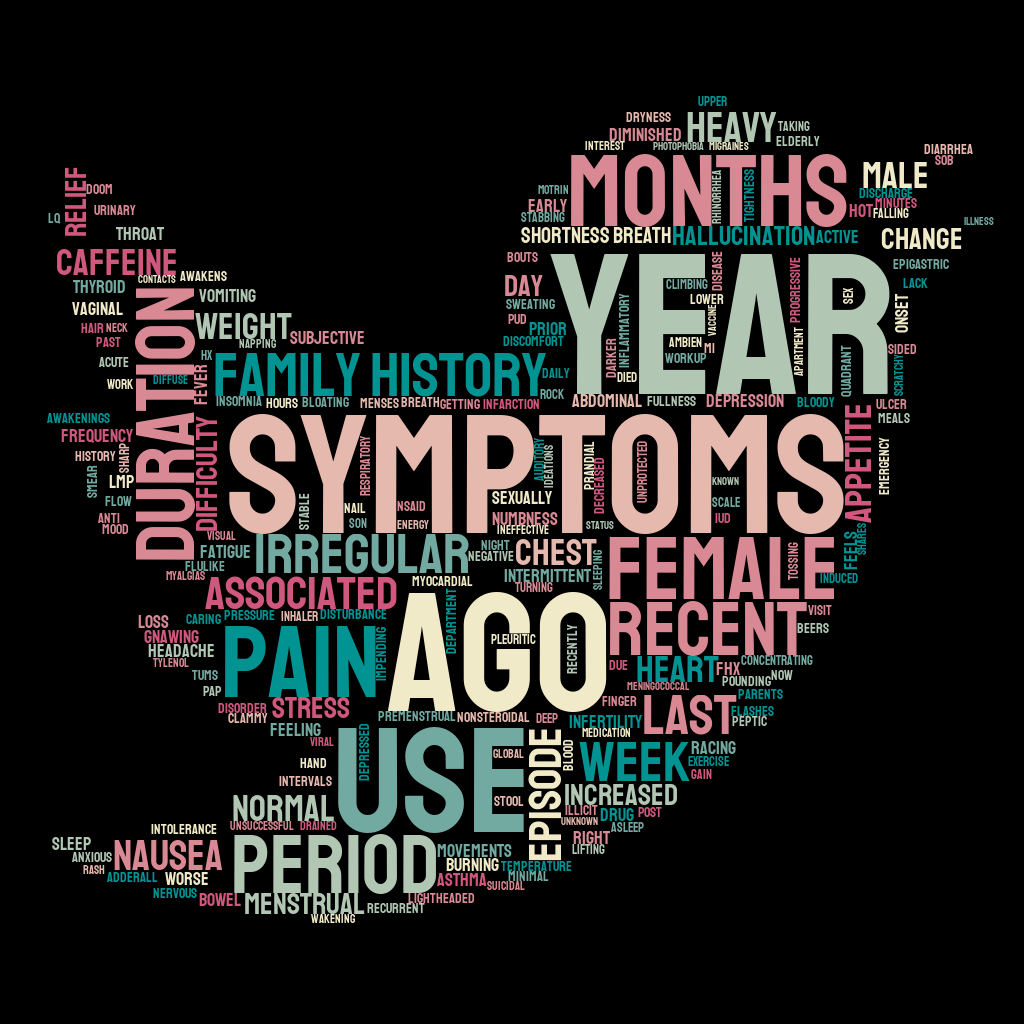

In [26]:
Image(filename="./stylecloud.png", width=1024, height=1024)

In [27]:
features.feature_text.value_counts()[:30]

Female                                                             7
Male                                                               3
20-year                                                            2
Nausea                                                             2
35-year                                                            2
17-year                                                            2
Family-history-of-MI-OR-Family-history-of-myocardial-infarction    1
Worse-with-deep-breath-OR-pleuritic                                1
Chest-pain                                                         1
Duration-x-1-day                                                   1
No-shortness-of-breath                                             1
Recent-heavy-lifting-at-work-OR-recent-rock-climbing               1
No-relief-with-asthma-inhaler                                      1
Sharp-OR-stabbing-OR-7-to-8-out-of-10-on-pain-scale                1
Weight-Gain                       

**WordCloud for Patient History**

In [28]:
concat_pnhist = ''.join([i for i in notes.pn_history.astype(str)])

concat_pnhist[:200]

"17-year-old male, has come to the student health clinic complaining of heart pounding. Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment\r\n-began 2-3 mo"

In [29]:
stylecloud.gen_stylecloud(text=concat_pnhist, icon_name= "fas fa-dharmachakra", 
                          palette="cartocolors.diverging.TealRose_7", background_color="black" , size=1024)

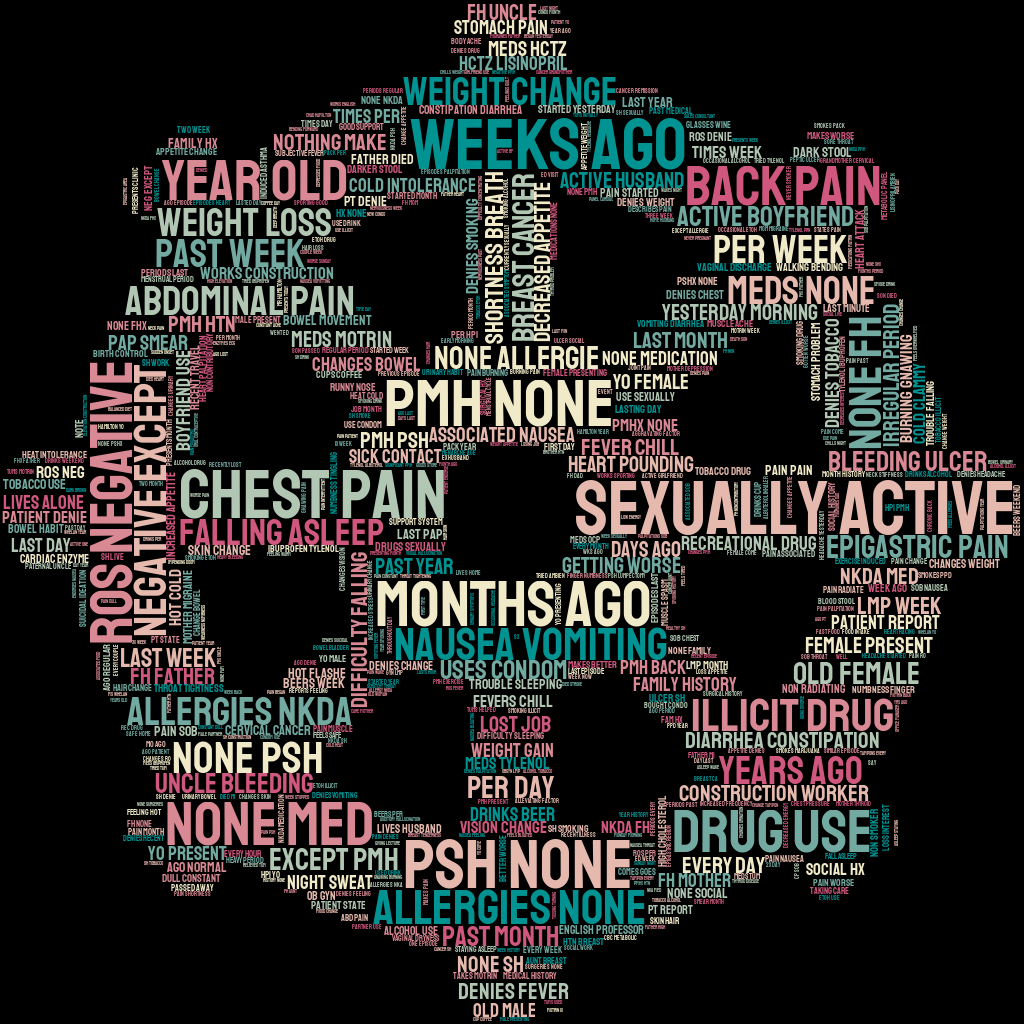

In [30]:
Image(filename="./stylecloud.png", width=1024, height=1024)

**Word Cloud for Annotations**

In [31]:
concat_annot = ' '.join([i for i in train.annotation.astype(str)])
print(concat_annot[:500])

['dad with recent heart attcak'] ['mom with "thyroid disease'] ['chest pressure'] ['intermittent episodes', 'episode'] ['felt as if he were going to pass out'] [] ['adderall', 'adderrall', 'adderrall'] [] [] ['palpitations', 'heart beating/pounding'] ['3-4 months of'] ['17yo'] ['M'] [] ['MOM HAS THYROID PROBLEMS'] ['PRESSURE ON HER CHEST'] ['COMES AND GOES', 'HAPPENED 5-6 TIMES'] [] [] [] ['SOB'] [] ['HEART POUNDING'] ['STARTED 2-3 MO AGO'] ['17 Y/O'] ['M'] ['father: heart attack'] ['mom: thyroi


In [32]:
stylecloud.gen_stylecloud(text=concat_annot,
                          icon_name='fas fa-yin-yang',
                          palette='colorbrewer.sequential.BuGn_9',
                          background_color='black',
                          gradient='horizontal',
                          size=1024)

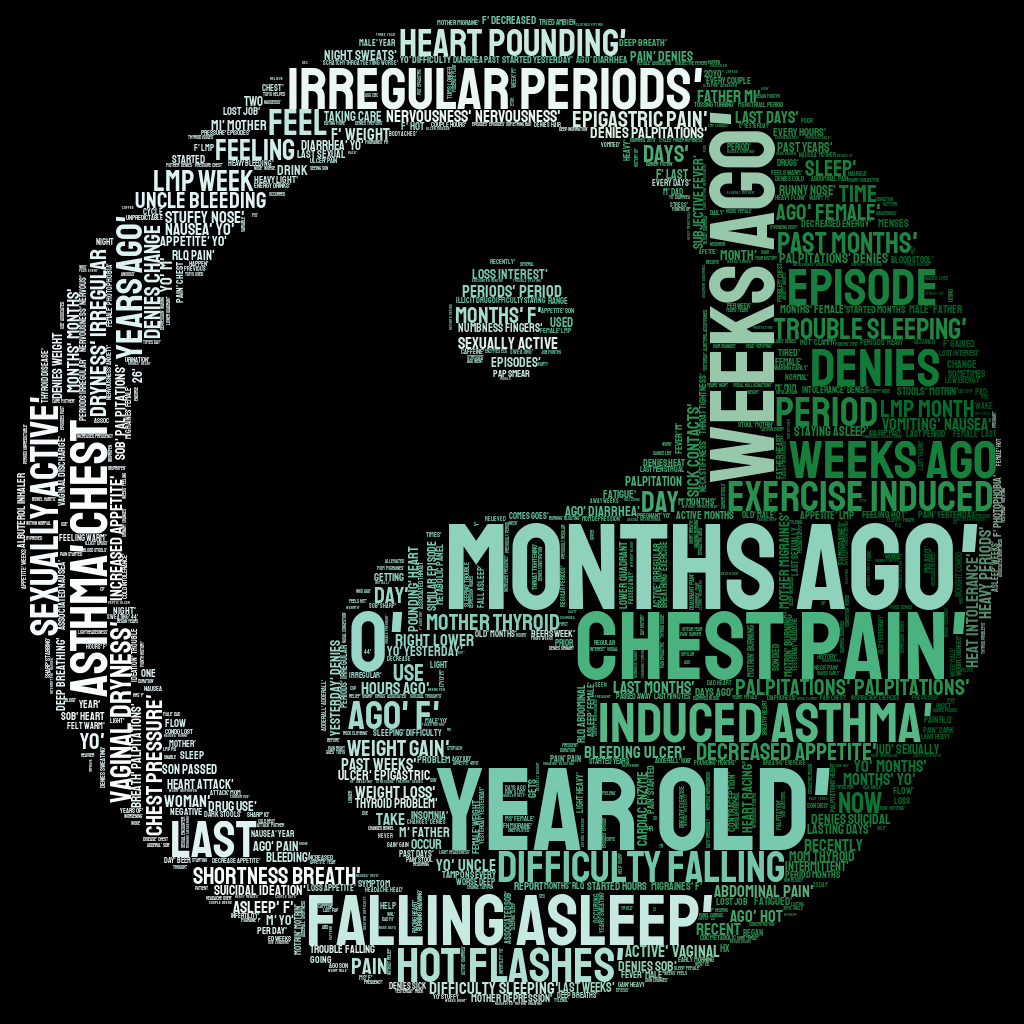

In [33]:
Image(filename="./stylecloud.png", width=1024, height=1024)